<a href="https://colab.research.google.com/github/thor4/nma-dl-pytorch/blob/master/tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/student/W3D1_Tutorial1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial 1: Un/Self-supervised learning methods

**Week 3, Day 1: Unsupervised and self-supervised learning**

**By Neuromatch Academy**

__Content creators:__ Arna Ghosh, Colleen Gillon, Tim Lillicrap, Blake Richards

__Content reviewers:__ Atnafu Lambebo, Hadi Vafaei, Khalid Almubarak, Melvin Selim Atay, Kelson Shilling-Scrivo

__Content editors:__ Anoop Kulkarni, Spiros Chalvis

__Production editors:__ Deepak Raya, Spiros Chalvis

**Our 2021 Sponsors, including Presenting Sponsor Facebook Reality Labs**

<p align='center'><img src='https://github.com/NeuromatchAcademy/widgets/blob/master/sponsors.png?raw=True'/></p>

---
# Tutorial Objectives

In this tutorial, you will learn about the importance of learning good representations of data.

Specific objectives for this tutorial:
*   Train logistic regressions (A) directly on input data and (B) on representations learned from the data.
*   Compare the classification performances achieved by the different networks.
*   Compare the representations learned by the different networks.
*   Identify the advantages of self-supervised learning over supervised or traditional unsupervised methods.

In [ ]:
# @title Tutorial slides

# @markdown These are the slides for the videos in this tutorial

# @markdown If you want to locally download the slides, click [here](https://osf.io/wvt34/download)
from IPython.display import IFrame
IFrame(src=f"https://mfr.ca-1.osf.io/render?url=https://osf.io/wvt34/?direct%26mode=render%26action=download%26mode=render", width=854, height=480)

---
# Setup

In [1]:
# @title Install dependencies

# @markdown Download dataset, modules, and files needed for the tutorial from GitHub.

# @markdown Download from OSF. Original repo: https://github.com/colleenjg/neuromatch_ssl_tutorial.git

import os, sys, importlib

REPO_PATH = "neuromatch_ssl_tutorial"
download_str = "Downloading"
if os.path.exists(REPO_PATH):
  download_str = "Redownloading"
  !rm -rf $REPO_PATH

# download from github repo directly
#!git clone git://github.com/colleenjg/neuromatch_ssl_tutorial.git --quiet

from io import BytesIO
from urllib.request import urlopen
from zipfile import ZipFile

zipurl = 'https://osf.io/smqvg/download'
print(f"{download_str} and unzipping the file... Please wait.")
with urlopen(zipurl) as zipresp:
  with ZipFile(BytesIO(zipresp.read())) as zfile:
    zfile.extractall()
print("Download completed!")


# @markdown Import modules designed for use in this tutorials
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util
from neuromatch_ssl_tutorial.modules import data, load, models, plot_util
importlib.reload(data);
importlib.reload(load);
importlib.reload(models)
importlib.reload(plot_util);


!pip install git+https://github.com/NeuromatchAcademy/evaltools --quiet
from evaltools.airtable import AirtableForm

# generate airtable form
atform = AirtableForm('appn7VdPRseSoMXEG','W3D1_T1','https://portal.neuromatchacademy.org/api/redirect/to/47de6f8f-1265-4a74-88c4-7dfa6e64b35a')

Download completed!


In [2]:
# Imports
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# @title Figure settings
import ipywidgets as widgets       # interactive display
#%matplotlib inline
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")

plt.rc('axes', unicode_minus=False) # to ensure negatives render correctly with xkcd style
import warnings
warnings.filterwarnings("ignore")

In [4]:
# @title Plotting functions

# @markdown Function to plot a histogram of RSM values: `plot_rsm_histogram(rsms, colors)`
def plot_rsm_histogram(rsms, colors, labels=None, nbins=100):
  fig, ax = plt.subplots(1)
  ax.set_title("Histogram of RSM values", y=1.05)

  min_val = np.min([np.nanmin(rsm) for rsm in rsms])
  max_val = np.max([np.nanmax(rsm) for rsm in rsms])

  bins = np.linspace(min_val, max_val, nbins+1)

  if labels is None:
    labels = [labels] * len(rsms)
  elif len(labels) != len(rsms):
    raise ValueError("If providing labels, must provide as many as RSMs.")

  if len(rsms) != len(colors):
    raise ValueError("Must provide as may colors as RSMs.")

  for r, rsm in enumerate(rsms):
    ax.hist(
        rsm.reshape(-1), bins, density=True, alpha=0.4,
        color=colors[r], label=labels[r]
        )
  ax.axvline(x=0, ls="dashed", alpha=0.6, color="k")
  ax.set_ylabel("Density")
  ax.set_xlabel("Similarity values")
  ax.legend()
  plt.show()

In [5]:
# @title Helper functions

from IPython.display import display, Image # to visualize images

# @markdown Function to set test custom torch RSM function: `test_custom_torch_RSM_fct()`
def test_custom_torch_RSM_fct(custom_torch_RSM_fct):
  rand_feats = torch.rand(100, 1000)
  RSM_custom = custom_torch_RSM_fct(rand_feats)
  RSM_ground_truth = data.calculate_torch_RSM(rand_feats)

  if torch.allclose(RSM_custom, RSM_ground_truth, equal_nan=True):
    print("custom_torch_RSM_fct() is correctly implemented.")
  else:
    print("custom_torch_RSM_fct() is NOT correctly implemented.")


# @markdown Function to set test custom contrastive loss function: `test_custom_contrastive_loss_fct()`
def test_custom_contrastive_loss_fct(custom_simclr_contrastive_loss):
  rand_proj_feat1 = torch.rand(100, 1000)
  rand_proj_feat2 = torch.rand(100, 1000)
  loss_custom = custom_simclr_contrastive_loss(rand_proj_feat1, rand_proj_feat2)
  loss_ground_truth = models.contrastive_loss(rand_proj_feat1,rand_proj_feat2)

  if torch.allclose(loss_custom, loss_ground_truth):
    print("custom_simclr_contrastive_loss() is correctly implemented.")
  else:
    print("custom_simclr_contrastive_loss() is NOT correctly implemented.")

In [6]:
#@title Set random seed

#@markdown Executing `set_seed(seed=seed)` you are setting the seed

# for DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [7]:
#@title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# inform the user if the notebook uses GPU or CPU.

def set_device():
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("WARNING: For this notebook to perform best, "
        "if possible, in the menu under `Runtime` -> "
        "`Change runtime type.`  select `GPU` ")
  else:
    print("GPU is enabled in this notebook.")

  return device

In [8]:
# Set global variables
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is enabled in this notebook.


In [9]:
# @markdown ### Pre-load variables (allows each section to be run independently)

# Section 1
dSprites = data.dSpritesDataset(
    os.path.join(REPO_PATH, "dsprites", "dsprites_subset.npz")
    )

dSprites_torchdataset = data.dSpritesTorchDataset(
  dSprites,
  target_latent="shape"
  )

train_sampler, test_sampler = data.train_test_split_idx(
  dSprites_torchdataset,
  fraction_train=0.8,
  randst=SEED
  )

supervised_encoder = load.load_encoder(REPO_PATH,
                                       model_type="supervised",
                                       verbose=False)

# Section 2
custom_torch_RSM_fct = None  # default is used instead

# Section 3
random_encoder = load.load_encoder(REPO_PATH,
                                   model_type="random",
                                   verbose=False)

# Section 4
vae_encoder = load.load_encoder(REPO_PATH,
                                model_type="vae",
                                verbose=False)

# Section 5
invariance_transforms = torchvision.transforms.RandomAffine(
    degrees=90,
    translate=(0.2, 0.2),
    scale=(0.8, 1.2)
    )
dSprites_invariance_torchdataset = data.dSpritesTorchDataset(
    dSprites,
    target_latent="shape",
    simclr=True,
    simclr_transforms=invariance_transforms
    )

# Section 6
simclr_encoder = load.load_encoder(REPO_PATH,
                                   model_type="simclr",
                                   verbose=False)

---
# Section 0: Introduction

In [ ]:
# @title Video 0: Introduction
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1D64y1s78e", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"Q3b_EqFUI00", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=Q3b_EqFUI00" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 0: Introduction')

display(out)

---
# Section 1: Representations are important

*Time estimate: ~30mins*

In [ ]:
# @title Video 1: Why do representations matter?
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1g54y1J7cE", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"lj5uTUo6W88", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=lj5uTUo6W88" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 1: Why do representations matter?')

display(out)

## Section 1.1: Introducing the dSprites dataset

In this tutorial, we will be using a subset of the openly available **dSprites dataset** to investigate the importance of learning good representations.  

_**Note on dataset:** For convenience, we will be using a subset of the original, full dataset which is available [here](https://github.com/deepmind/dsprites-dataset/), on GitHub._

### Interactive Demo 1.1.1: Exploring the dSprites dataset

In this first demo, we will get to know the **dSprites dataset**. This dataset is made up of black and white images (20,000 images total in the subset we are using).  

The images in the dataset can be described using different combinations of **latent dimension values**, sampled from:
- **Shapes (3):** square (1.0), oval (2.0) or heart (3.0)
- **Scales (6):** 0.5 to 1.0
- **Orientations (40):** 0 to 2$\pi$
- **Positions in X (32):** 0 to 1 (left to right)
- **Positions in Y (32):** 0 to 1 (top to bottom)

As a result, **each image carries 5 labels.** One for each of the latent dimensions.  

We will first load the dataset into the `dSprites` object, which is an instance of the `data.dSpritesDataset` class.


In [10]:
dSprites = data.dSpritesDataset(
    os.path.join(REPO_PATH, "dsprites", "dsprites_subset.npz")
    )

Next, we use the `dSpritesDataset` class method `show_images()` to plot a few images from the dataset, with their latent dimension values printed below.    

**Interactive Demo:** View a different set of randomly sampled images by passing the random state argument `randst` any integer or the value `None`. (The original setting is `randst=SEED`.)

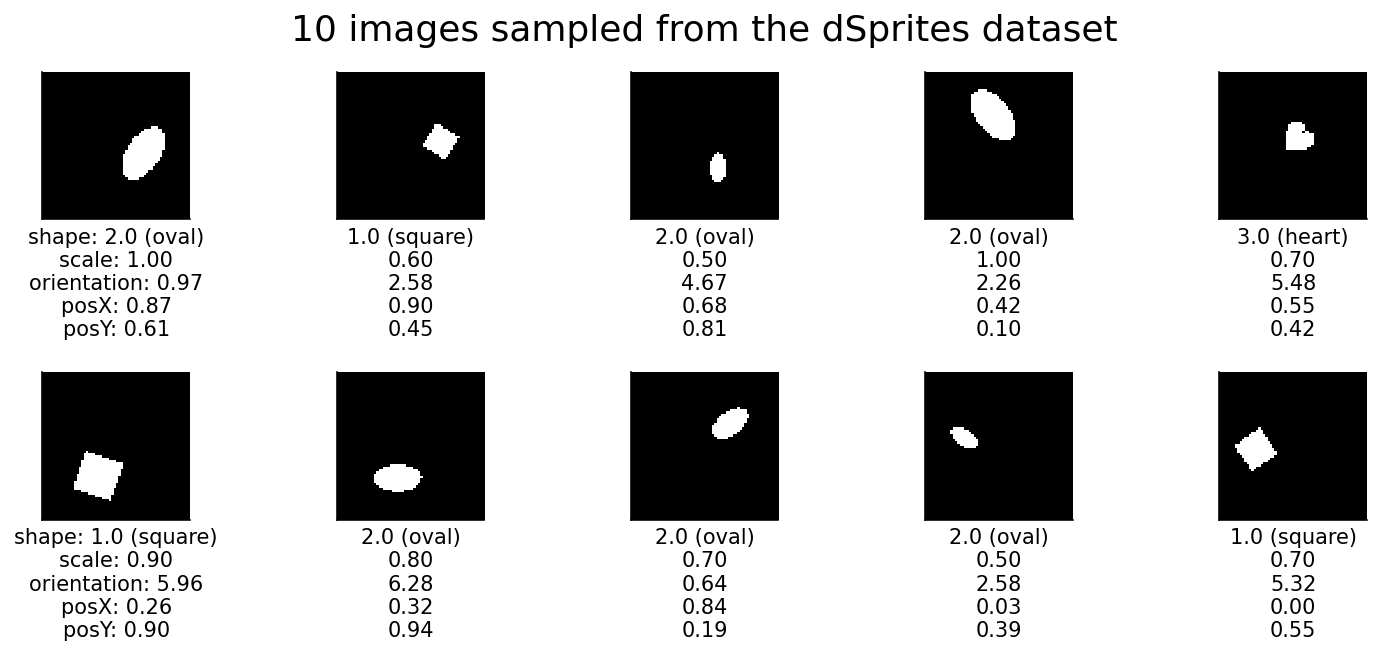

In [11]:
# DEMO: to view different images, set randst to any integer value.
dSprites.show_images(num_images=10, randst=SEED)

To better understand the `posX` and `posY` latent dimensions (which will be most relevant in **Bonus 2**), we plot the images with some annotations. The annotations (in red) do not modify the actual images; they are added **purely for visualization purposes**, and show:  
  -  the **edges** of the `posX` and `posY` spans, and
  - the **center**, i.e. `(posX, posY)`, for each shape.

_**Note on shape positions:** Notice that all shape centers are positioned **within the area marked by the red square**. `posX` and `posY` actually describe the relative position of the center of a shape within this area: `posX=0` (left) to `posX=1` (right), and `posY=0` (top) to `posY=1` (bottom). No shape center appears outside, in the buffer area. This choice in the dSprites dataset design ensures that shapes of different scales and rotations **all appear fully**._ 

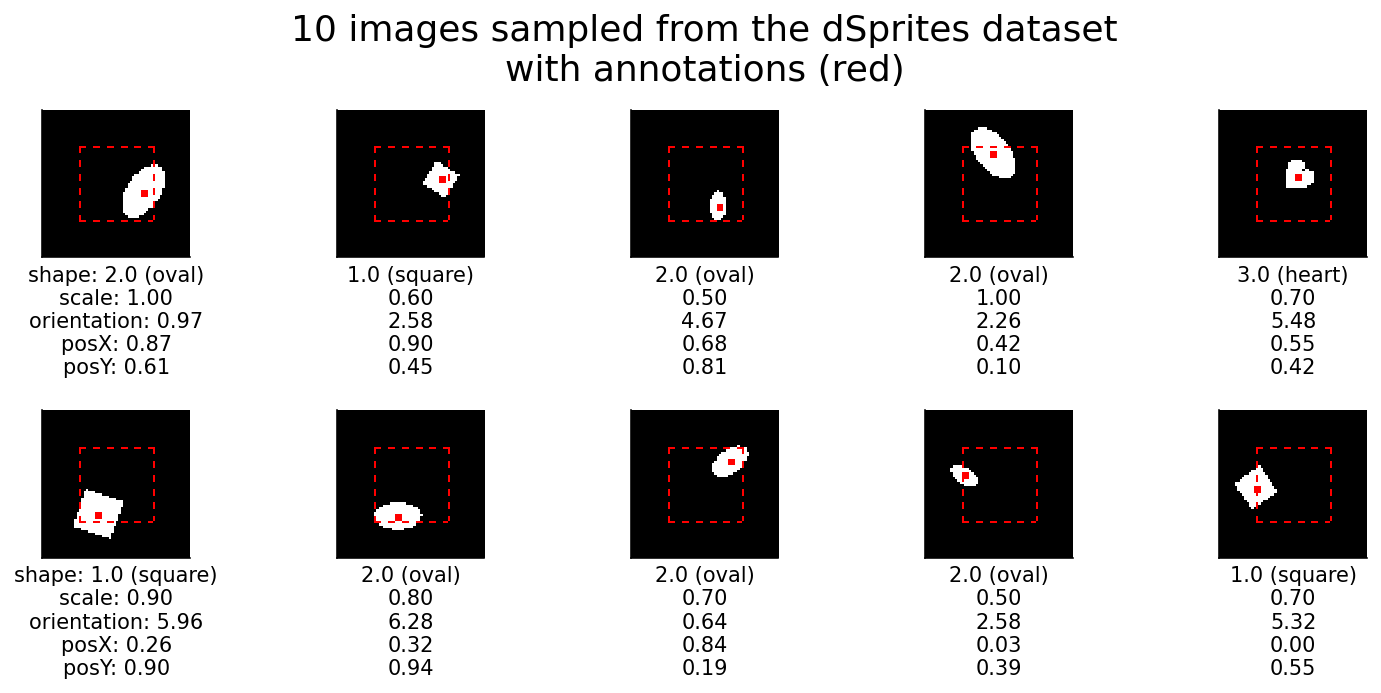

In [12]:
# DEMO: to view different images, set randst to any integer value.
dSprites.show_images(num_images=10, randst=SEED, annotations="pos")

## Section 1.2: Training a classifier with and without representations

Now, we will investigate how 2 different types of classifiers perform when trained to decode the shape latent dimension of images in the **dSprites dataset**.  

Specifically, we will train **one classifier directly on the images**, and **another on the output of an encoder network**.

The **encoder network** we will use here and throughout the tutorial is the multi-layer convolutional network, pictured below. It comprises 2 consecutive convolutional layers, followed by 3 fully connected layers, and uses average pooling and batch normalization between layers, as well as rectified linear units as non-linearities. 

The **classifier layer** then takes the encoder features as input, predicting, for example, the shape latent dimension of encoded input images.

_**Note on terminology:** In this tutorial, both the terms **representations** and **features** are used to refer to the data embeddings learned in the final layer of the encoder network (of dimension 1x84, and indicated by a red dashed box) which are fed to the classifiers._

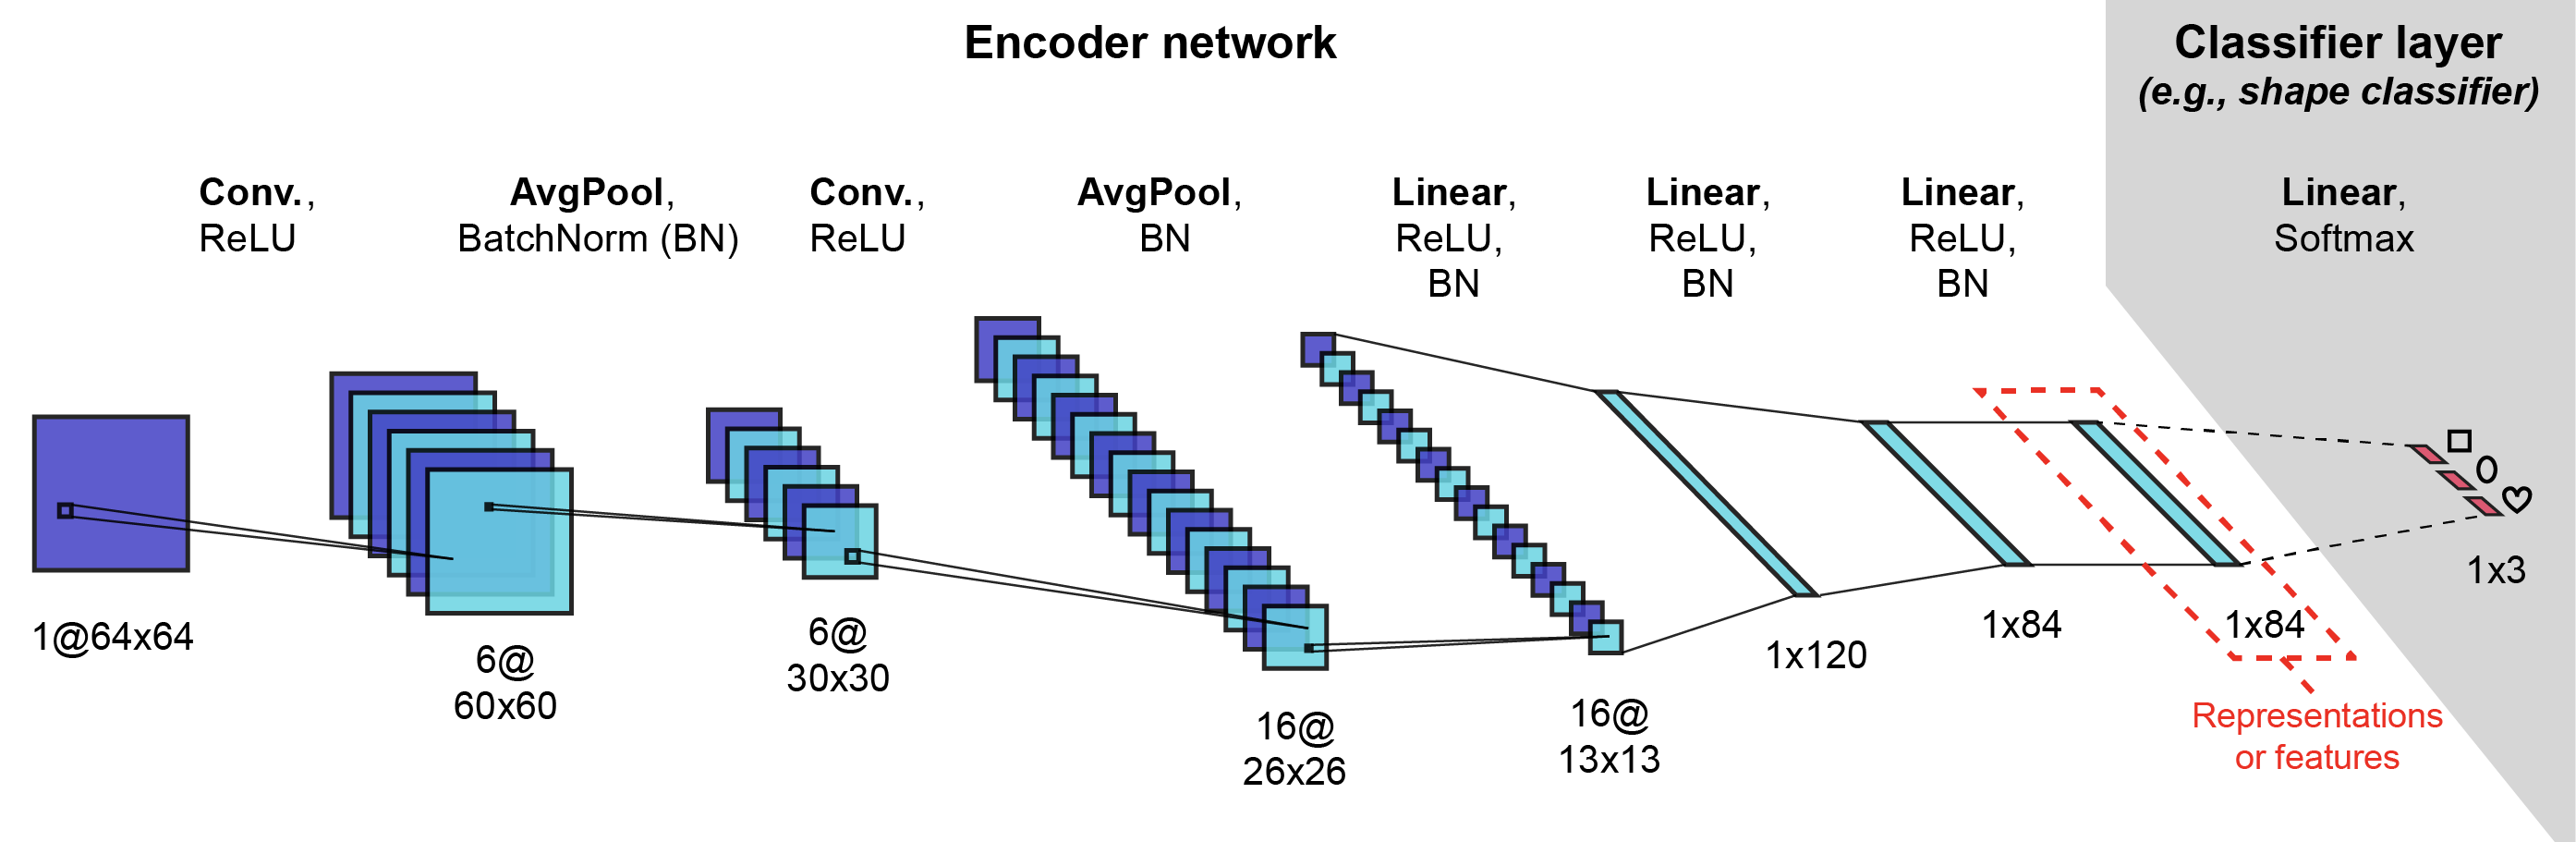

In [17]:
# @markdown ### Encoder network schematic
Image(filename=os.path.join(REPO_PATH, "images", "feat_encoder_schematic.png"), width=1200)

The following code:
*    seeds modules that will use random processes, to ensure the results are consistently reproducible, using the `seed_processes()` function,
*    collects the dSprites dataset into a torch dataset using the `data.dSpritesTorchDataset` class, 
*    initializes a training and a test sampler to keep the two datasets separate using the `data.train_test_splix_idx()` function.

In [13]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

# initialize a torch dataset, specifying the target latent dimension for
# the classifier
dSprites_torchdataset = data.dSpritesTorchDataset(
  dSprites,
  target_latent="shape"
  )

# initialize a train_sampler and a test_sampler to keep the two sets
# consistently separate
train_sampler, test_sampler = data.train_test_split_idx(
  dSprites_torchdataset,
  fraction_train=0.8,  # 80:20 data split
  randst=SEED
  )

print(f"Dataset size: {len(train_sampler)} training, "
      f"{len(test_sampler)} test images")

Random seed 2021 has been set.
Dataset size: 16000 training, 4000 test images


### Interactive Demo 1.2.1: Training a logistic regression classifier directly on images

The following code:
*    trains a logistic regression directly on the training set images to classify their shape, and assesses its performance on the test set images using the `models.train_classifier()` function.

**Interactive Demo:** Try a few different `num_epochs` settings to see whether performance improves with more training, e.g., between 1 and 50 epochs. (The original setting is `num_epochs=25`).

In [14]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

num_epochs = 40  # DEMO: Try different numbers of training epochs

# train a classifier directly on the images
print("Training a classifier directly on the images...")
_ = models.train_classifier(
  encoder=None,
  dataset=dSprites_torchdataset,
  train_sampler=train_sampler,
  test_sampler=test_sampler,
  freeze_features=True, # there is no feature encoder to train here, anyway
  num_epochs=num_epochs,
  verbose=True # print results
  )

Random seed 2021 has been set.
Training a classifier directly on the images...


  0%|          | 0/40 [00:00<?, ?it/s]

Network performance after 40 classifier training epochs (chance: 33.33%):
    Training accuracy: 53.72%
    Testing accuracy: 40.88%


As we can observe, the classifier trained directly on the images performs only a bit above chance (39.55%) on the test set, after 25 training epochs.

<b>Shape classification results using different feature encoders:

| _Chance_ |  | None (raw data) |
| - | - | --- |
| _33.33%_ |  | 39.55% |

### Coding Exercise 1.2.1: Training a logistic regression classifier along with an encoder

The following code:
*    uses the same dSprites torch dataset (`dSprites_torchdataset`) initialized above, as well as the training and test samplers (`train_sampler`, `test_sampler`),
*    again, seeds modules that will use random processes, to ensure the results are consistently reproducible,
*    initializes an encoder network to use in the supervised network using the `models.EncoderCore` class,
*    sets a proposed number of epochs to use when training the classifier and encoder (`num_epochs=10`). 

**Exercise:** Train a classifier, along with the encoder, to classify the input images according to shape, using `models.train_classifier()`. How does it perform?

**Hints**: 
- `models.train_classifier()`:
    - is introduced in **Interactive Demo 1.2.1**.
    - takes `freeze_features` as an input argument:
        - if set to `True`, the encoder is frozen, and so only the classifier layer is trained.
        - if set to `False`, the encoder is **not** frozen, and is trained along with the classifier layer.

In [21]:
def train_supervised_encoder(num_epochs, seed):
  # call this before any dataset/network initializing or training,
  # to ensure reproducibility
  set_seed(seed)

  # initialize a core encoder network on which the classifier will be added
  supervised_encoder = models.EncoderCore()

  # EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
  print("Training a supervised encoder and classifier...")
  _ = models.train_classifier(
      encoder=supervised_encoder,
      dataset=dSprites_torchdataset,
      train_sampler=train_sampler,
      test_sampler=test_sampler,
      freeze_features=False,
      num_epochs=num_epochs,
      verbose=True  # print results
      )

  return supervised_encoder


# add event to airtable
atform.add_event('Coding Exercise 1.2.1: Training a logistic regression classifier along with an encoder')

num_epochs = 10 # Proposed number of training epochs
## Uncomment below to test your function
supervised_encoder = train_supervised_encoder(num_epochs=num_epochs, seed=SEED)

Random seed 2021 has been set.
Training a supervised encoder and classifier...


  0%|          | 0/10 [00:00<?, ?it/s]

Network performance after 10 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 100.00%
    Testing accuracy: 98.72%


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_5e4906f2.py)



```
Network performance after 10 encoder and classifier training epochs (chance: 33.33%):
    Training accuracy: 100.00%
    Testing accuracy: 98.38%
````

When the classifier is trained with an encoder network, however, it achieves very high classification accuracy (98.72%) on the test set, after only 10 training epochs.

<b>Shape classification results using different feature encoders:

| _Chance_ |  | None (raw data) | Supervised |
| - | - | --- | --- |
| _33.33%_ |  | 39.55% | 98.38% |

---
# Section 2: Supervised learning induces invariant representations

*Time estimate: ~20mins*

In [ ]:
# @title Video 2: Supervised Learning and Invariance
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1d54y1E76W", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"ZQka4k8ZOs0", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=ZQka4k8ZOs0" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 2: Supervised Learning and Invariance')

display(out)

## Section 2.1: Examining Representational Similarity Matrices (RSMs)

To examine the representations learned by the encoder network, we use **Representational Similarity Matrices (RSMs)**. In these matrices, the similarity between the encoder's representations of each possible pair of images is plotted to reveal overall structure in representation space.  

_**Note on cosine similarity:** Here, we use cosine similarity as a measure of representational similarity. Cosine similarity measures the angle between 2 vectors, and can be thought of as their normalized dot product._

### Coding Exercise 2.1.1: Complete a function that calculates RSMs

The following code:
*    lays out the skeleton of a function `custom_torch_RSM_fct()` which calculates an RSM from features,
*    tests the custom function against the solution implementation.

**Exercise:** Complete the `custom_torch_RSM_fct()` implementation.

**Hints**: 
- `custom_torch_RSM_fct()`: 
    - takes 1 input argument:
        - `features` (2D torch Tensor): feature matrix (nbr items x nbr features)
    - returns 1 output:
        - `rsm` (2D torch Tensor): similarity matrix (nbr items x nbr items)
    - uses `torch.nn.functional.cosine_similarity()`.
- `torch.nn.functional.cosine_similarity()`:
    - takes 3 arguments, in order: 
        - `x1` (torch Tensor),
        - `x2` (torch Tensor), 
        - `dim` (int)
    - returns the similarity between `x1` and `x2` along dimension `dim`.

**Detailed hint**: 
- To use `torch.nn.functional.cosine_similarity()` to measure the similarity of `features` to **itself** for each possible **pair of items**:
    - Pass 2 versions of `features` as `x1` and `x2`, respectively. 
    - Ensure that for `x1` and `x2`, the **features dimension is at the same position** , and specify that dimension with `dim`.
    - To obtain the similarity between each possible pair of items, ensure that for `x1` and `x2`, the **items dimensions are orthogonal** to one another (i.e., at different positions).
    - Don't forget that to achieve this, singleton dimensions (i.e., dimensions of length 1) can be used.

In [16]:
def custom_torch_RSM_fct(features):
  """
  custom_torch_RSM_fct(features)

  Custom function to calculate representational similarity matrix (RSM) of a feature
  matrix using pairwise cosine similarity.

  Complete the function below given the specific guidelines.
  Uses torch.nn.functional.cosine_similarity()

  Required args:
  - features (2D torch Tensor): feature matrix (nbr items x nbr features)

  Returns:
  - rsm (2D torch Tensor): similarity matrix
      (nbr items x nbr items)
  """

  num_items, num_features = features.shape

  # EXERCISE: Implement RSM calculation
  rsm = torch.nn.functional.cosine_similarity(
      features.reshape(1,num_items,num_features), #num_features same pos
      features.reshape(num_items,1,num_features), #num_items orthogonal
      dim=2) #dim of features

  if not rsm.shape == (num_items, num_items):
    raise ValueError(
        f"RSM should be of shape ({num_items}, {num_items})"
        )

  return rsm


# add event to airtable
atform.add_event('Coding Exercise 2.1.1: Complete a function that calculates RSMs')

## Test implementation by comparing output to solution implementation
test_custom_torch_RSM_fct(custom_torch_RSM_fct)

custom_torch_RSM_fct() is correctly implemented.


[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_dc090f74.py)



```
custom_torch_RSM_fct() is correctly implemented.
```

### Interactive Demo 2.1.1: Plotting the supervised network encoder RSM along different latent dimensions

In this demo, we calculate an RSM for representations of the test set images generated by the supervised network encoder. 

The following code:
*    calculates and plots the RSM for the test set, with rows and columns sorted by whichever latent dimension is specified (e.g., `sorting_latent="shape"`) using `models.plot_model_RSMs()`.

**Interactive Demo:** In the current example, the rows and columns of the RSM are organized along the `shape` latent dimension. Try organizing them along one of the other latent dimensions (`"scale"`, `"orientation"`, `"posX"` or `"posY"`) to see whether different patterns emerge. (The original setting is `sorting_latent="shape"`.)

Plotting RSMs...


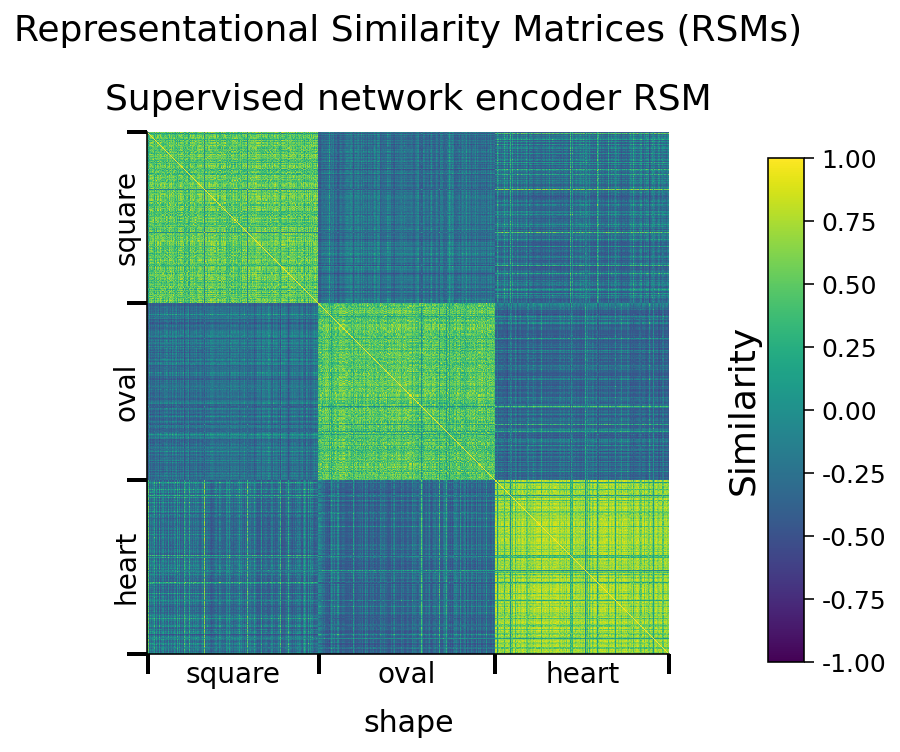

In [21]:
sorting_latent = "shape" # DEMO: Try sorting by different latent dimensions
print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder], # we pass the trained supervised_encoder
    dataset=dSprites_torchdataset,
    sampler=test_sampler, # we want to see the representations on the held out test set
    titles=["Supervised network encoder RSM"], # plot title
    sorting_latent=sorting_latent,
    RSM_fct=custom_torch_RSM_fct
    )

### Discussion 2.1.1: What patterns do the RSMs reveal about how the encoder represents different images? 
**A.** What does the yellow (maximal similarity color) diagonal, going from the top left to the bottom right, correspond to?  
**B.** What pattern can be observed when comparing RSM values for pairs of images that share a similar latent value (e.g., 2 heart images) vs pairs of images that do not (e.g., a heart and a square image)?   
**C.** Do some shapes appear to be encoded more similarly than others?  
**D.** Do some latent dimensions show clearer RSM patterns than others? Why might that be so?

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q1' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_f276340a.py)



In [ ]:
# @markdown ### Supporting images for Discussion response examples for 2.1.1

Image(filename=os.path.join(REPO_PATH, "images", "rsms_supervised_encoder_10ep_bs1000_seed2021.png"), width=1200)

---
# Section 3: Random projections don’t work as well

*Time estimate: ~20mins*


In [ ]:
# @title Video 3: Random Representations
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Jf4y15789", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"LVM7Fm5T6Fs", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 3: Random Representations')

display(out)

## Section 3.1: Examining RSMs of a random encoder

To determine whether the patterns observed in the RSMs of the supervised network encoder are trivial, we investigate whether they also emerge from the **random projections of an untrained encoder**.

### Coding Exercise 3.1.1: Plotting a random network encoder RSM along different latent dimensions

In this exercise, we repeat the same analysis as in **Section 2.1**, but with a random encoder.  

The following code:
*    initializes an encoder network to use in the random network using the `models.EncoderCore` class,
*    proposes a latent dimension along which to sort the rows and columns (`sorting_latent = "shape"`).

**Exercise:** 
*    Visualize the RSMs for the supervised and random network encoders, using `models.plot_model_RSMs()`. 
*    Visualize the RSMs, organized along different latent dimensions (`"scale"`, `"orientation"`, `"posX"` or `"posY"`), and compare the patterns observed for the supervised versus the random encoder network.

**Hint**: `models.plot_model_RSMs()` is introduced in **Interactive Demo 2.1.1**.

In [ ]:
def plot_rsms(seed):
  # call this before any dataset/network initializing or training,
  # to ensure reproducibility
  set_seed(seed)

  # initialize a core encoder network that will not get trained
  random_encoder = models.EncoderCore()

  # EXERCISE: Try sorting by different latent dimensions
  sorting_latent = "shape"

  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your implementation
  raise NotImplementedError("Exercise: Plot RSMs.")
  #################################################
  # EXERCISE: Plot RSMs
  print("Plotting RSMs...")
  _ = models.plot_model_RSMs(
      encoders=[..., ...],  # we pass both encoders
      dataset=...,
      sampler=...,  # we want to see the representations on the held out test set
      titles=["Supervised network encoder RSM",
              "Random network encoder RSM"],  # plot titles
      sorting_latent=sorting_latent,
      )

  return random_encoder


# add event to airtable
atform.add_event('Coding Exercise 3.1.1: Plotting a random network encoder RSM along different latent dimensions')

## Uncomment below to test your function
# random_encoder = plot_rsms(seed=SEED)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_8bd81b66.py)

*Example output:*

<img alt='Solution hint' align='left' width=1509.0 height=752.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/static/W3D1_Tutorial1_Solution_8bd81b66_1.png>



### Discussion 3.1.1: What does comparing these RSMs reveal about the potential value of trained versus random encoder representations? 

**A.** What patterns, if any, are visible in the random network encoder RSM?   
**B.** Which encoder network is most likely to produce meaningful representations?

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q2' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_8b06362b.py)



In [ ]:
# @markdown ### Supporting images for Discussion response examples for 3.1.1: All random encoder RSMs

Image(filename=os.path.join(REPO_PATH, "images", "rsms_random_encoder_0ep_bs0_seed2021.png"), width=1000)

### Coding Exercise 3.1.2: Evaluating the classification performance of a logistic regression trained on the representations produced by a random network encoder

In this exercise, we repeat a similar analysis to **Section 1.2**, but with the random encoder network. Importantly, this time, the encoder parameters must stay frozen during training by setting `freeze_features=True`. Instead of being provided ahead of time a suggestion for a reasonable number of training epochs, we use the training loss array to select a good value.  


The following code:
*    trains a logistic regression on top of the random encoder network to classify images based on shape, and assesses its performance on the test set images using `models.train_classifier()` with `freeze_features=True` to ensure that the encoder is **not** trained, and only the classifier is.

**Exercise:** 
*     Set a number of epochs for which to train the classifier.  
*     Plot the training loss array (`random_loss_array`, i.e. training loss at each epoch) returned when training the model.  
*     Rerun the classifier if more training epochs are needed based on the progression of the training loss.


In [ ]:
def plot_loss(num_epochs, seed):
  # call this before any dataset/network initializing or training,
  # to ensure reproducibility
  set_seed(seed)

  # train classifier on the randomly encoded images
  print("Training a classifier on the random encoder representations...")
  _, random_loss_array, _, _ = models.train_classifier(
      encoder=random_encoder,
      dataset=dSprites_torchdataset,
      train_sampler=train_sampler,
      test_sampler=test_sampler,
      freeze_features=True,  # keep the encoder frozen while training the classifier
      num_epochs=num_epochs,
      verbose=True  # print results
      )
  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your implementation
  raise NotImplementedError("Exercise: Plot loss array.")
  #################################################
  # EXERCISE: Plot the loss array
  fig, ax = plt.subplots()
  ax.plot(...)
  ax.set_title(...)
  ax.set_xlabel(...)
  ax.set_ylabel(...)

  return random_loss_array


# add event to airtable
atform.add_event('Coding Exercise 3.1.2: Evaluating the classification performance of a logistic regression')

## Set a reasonable number of training epochs
num_epochs = 25
## Uncomment below to test your plot
# random_loss_array = plot_loss(num_epochs=num_epochs, seed=SEED)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_f560c6ba.py)

*Example output:*

<img alt='Solution hint' align='left' width=1116.0 height=827.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/static/W3D1_Tutorial1_Solution_f560c6ba_3.png>



```
Network performance after 25 classifier training epochs (chance: 33.33%):
    Training accuracy: 46.02%
    Testing accuracy: 44.67%
```

The network loss training is fairly stable by 25 epochs, at which point the classifier performs at 44.67% accuracy on the test dataset. 

<b>Shape classification results using different feature encoders:

| _Chance_ |  | None (raw data) | Supervised | Random |
| - | - | --- | --- | --- |
| _33.33%_ |  | 39.55% | 98.38% | 44.67% |

### Discussion 3.1.2: What can we conclude about the potential consequences of using random projections with a dataset like dSprites? 

**A.** How does the classifier performance compare to the classifier trained directly on the images?  
**B.** How does the classifier performance compare to the classifier trained along with the encoder (supervised encoder)?  
**C.** What explains these different performances?  

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q3' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_28e6be8a.py)



---
# Section 4: Generative approaches to representation learning can fail

*Time estimate: ~30mins*


In [ ]:
# @title Video 4: Generative models
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1YP4y147UT", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"NUittg0EKSM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 4: Generative models')

display(out)

## Section 4.1: Examining the RSMs of a Variational Autoencoder

We next ask what kind of representations a network can learn in the absence of labelled data. We first look at a **generative model**, namely the **Variational Autoencoder (VAE)**.  

Given that generative models typically require more training than supervised models, instead of pre-training a network here, we will load one that was **pre-trained for 300 epochs**. Importantly, the **encoder shares the same architecture** as the one used for the supervised and random examples above.

The following code:
*    loads the parameters of a full VAE network (encoder and decoder) pre-trained on the generative task of reconstructing the input images, under the Kullback–Leibler divergence (KLD) minimization constraint over the latent space that characterizes VAEs, using `load.load_encoder()` and `load.load_decoder()`.

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

# Load VAE encoder and decoder pre-trained on the reconstruction and KLD tasks
vae_encoder = load.load_encoder(REPO_PATH, model_type="vae")
vae_decoder = load.load_vae_decoder(REPO_PATH)

### Interactive Demo 4.1.1: Plotting example reconstructions using the pre-trained VAE encoder and decoder

In this demo, we sample images from the test set, and take a look at the quality of the reconstructions using `models.plot_vae_reconstructions()`.  

**Interactive Demo:** Try plotting different images from the test dataset by selecting different `test_sampler.indices` values. (Original setting is `indices=test_sampler.indices[:10]`.)

In [ ]:
models.plot_vae_reconstructions(
    vae_encoder,  # pre-trained encoder
    vae_decoder,  # pre-trained decoder
    dataset=dSprites_torchdataset,
    indices=test_sampler.indices[:10],  # DEMO: select different indices to plot from the test set
    title="VAE test set image reconstructions",
    )

### Discussion 4.1.1: How does the VAE perform on the reconstruction task? 
**A.** Which latent features does the network appear to preserve well, and which does it preserve less well?  
**B.** Based on the reconstruction performance, what do you expect to see in the different RSMs?  

_**Note on reconstruction quality:** This VAE network uses a basic VAE loss with a convolutional encoder (our core encoder network), and a deconvolutional decoder. This can lead to some blurriness in the reconstructed shapes which a more sophisticated VAE could overcome._

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_b1fd9be0.py)



### Interactive Demo 4.1.2: Visualizing the VAE encoder RSMs, organized along different latent dimensions

We will now compare the pre-trained VAE encoder network RSM to the previously generated encoder RSMs. 

**Interactive Demo:** Visualize the RSMs, organized along different latent dimensions (`"scale"`, `"orientation"`, `"posX"` or `"posY"`), and compare the patterns observed for the different encoder networks. (The original setting is `sorting_latent="shape"`.)

In [ ]:
sorting_latent = "shape" # DEMO: Try sorting by different latent dimensions
print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder, random_encoder, vae_encoder], # we pass all three encoders
    dataset=dSprites_torchdataset,
    sampler=test_sampler, # we want to see the representations on the held out test set
    titles=["Supervised network encoder RSM", "Random network encoder RSM",
            "VAE network encoder RSM"], # plot titles
    sorting_latent=sorting_latent,
    )

### Discussion 4.1.2: What can we conclude about the the ability of generative models like VAEs to construct a meaningful representation space?

**A.** What structure can be observed in the pre-trained VAE encoder RSMs when sorted along the different latent dimensions, and what does that suggest about the feature space learned by the VAE encoder?  
**B.** How do the pre-trained VAE encoder RSMs compare to the supervised and random encoder network RSMs?  
**C.** What explains these different RSMs?  
**D.** How well will the pre-trained VAE encoder likely perform on the shape classification task, as compared to the other encoder networks?  
**E.** Might the pre-trained VAE encoder be better suited to predicting a different latent dimension?

In [ ]:
# @title Student Response
from ipywidgets import widgets


text=widgets.Textarea(
   value='Type your answer here and click on `Submit!`',
   placeholder='Type something',
   description='',
   disabled=False
)

button = widgets.Button(description="Submit!")

display(text,button)

def on_button_clicked(b):
   atform.add_answer('q4' , text.value)
   print("Submission successful!")


button.on_click(on_button_clicked)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_b7aba28a.py)



In [ ]:
# @markdown ### Supporting images for Discussion response examples for 4.1.2: All VAE encoder RSMs

Image(filename=os.path.join(REPO_PATH, "images", "rsms_vae_encoder_300ep_bs500_seed2021.png"), width=1000)

### Coding Exercise 4.1.2: Evaluating the classification performance of a logistic regression trained on the representations produced by the pre-trained VAE network encoder

For the pre-trained VAE encoder, as the encoder parameters have already been trained, they should be kept frozen while the classifier is trained by setting `freeze_features=True`.   

**Exercise:** 
*     Set a number of epochs for which to train the classifier.  
*     Train a classifier, along with the encoder, to classify the input images according to shape, using `models.train_classifier()`.
*     Plot the loss array returned when training the model, and update the number of training epochs, if needed. 

**Hint**: `models.train_classifier()` is introduced in **Interactive Demo 1.2.1**.

In [ ]:
def vae_train_loss(num_epochs, seed):
  # call this before any dataset/network initializing or training,
  # to ensure reproducibility
  set_seed(seed)
  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your implementation
  raise NotImplementedError("Exercise: Train a classifer on the pre-trained VAE encoder representations.")
  #################################################
  # EXERCISE: Train an encoder and classifier on the images, using models.train_classifier()
  print("Training a classifier on the pre-trained VAE encoder representations...")
  _, vae_loss_array, _, _ = models.train_classifier(
      encoder=...,
      dataset=...,
      train_sampler=...,
      test_sampler=...,
      freeze_features=..., # keep the encoder frozen while training the classifier
      num_epochs=...,
      verbose=... # print results
      )
  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your implementation
  raise NotImplementedError("Exercise: Plot the VAE classifier training loss.")
  #################################################
  # EXERCISE: Plot the VAE classifier training loss.
  fig, ax = plt.subplots()
  ax.plot(...)
  ax.set_title(...)
  ax.set_xlabel(...)
  ax.set_ylabel(...)

  return vae_loss_array


# add event to airtable
atform.add_event('Coding Exercise 4.1.2: Evaluating the classification performance of a logistic regression - VAE encoder')

# Set a reasonable number of training epochs
num_epochs = 25
## Uncomment below to test your function
# vae_loss_array = vae_train_loss(num_epochs=num_epochs, seed=SEED)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_c2a3feeb.py)

*Example output:*

<img alt='Solution hint' align='left' width=1116.0 height=827.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/static/W3D1_Tutorial1_Solution_c2a3feeb_3.png>



The network loss training is fairly stable by 25 epochs, at which point the classifier performs at 45.75% accuracy on the test dataset.  

```
Network performance after 25 classifier training epochs (chance: 33.33%):
    Training accuracy: 46.48%
    Testing accuracy: 45.75%
````

<b>Shape classification results using different feature encoders:

| _Chance_ |  | None (raw data) | Supervised | Random | VAE |
| - | - | --- | --- | --- | --- |
| _33.33%_ |  | 39.55% | 98.38% | 44.67% | 45.75% |

---
# Section 5: The modern approach to self-supervised training for invariance

*Time estimate: ~10mins*

In [ ]:
# @title Video 5: Modern Approach in Self-supervised Learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Bv411n7zP", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"hUWcsSFWZyw", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 5: Modern Approach in Self-supervised Learning')

display(out)

## Section 5.1: Examining different options for learning invariant representations.

We now take a look at a few options for learning invariant shape representations for a dataset such as **dSprites**.

### Interactive Demo 5.1.1: Visualizing a few different image transformations available that could be used to learn invariance

The following code:
*    initializes a set of transforms called `invariance_transforms` using the `torchvision.transforms.RandomAffine` class,
*    collects the dSprites dataset into a torch dataset `dSprites_invariance_torchdataset` which takes the `invariance_transforms` as input and deploys the transforms when it is called, 
*    shows a few examples of images and their transformed versions using the `data.dSpritesTorchDataset` `show_images()` method. 

The `torchvision.transforms.RandomAffine` class enables us to predetermine which types and ranges of transforms will be sampled from when transforming the images, by setting the following arguments:
*    `degrees`: absolute maximum number of degrees to rotate
*    `translate`: absolute maximum proportion of width to shift in x, and of height to shift in y
*   `scale`: minimum to maximum scaling factor

**Interactive Demo:** Try out a few combinations of the transformation parameters, and visualize the pairs of transformations of the same image. (The original settings are `degrees=90`, `translate=(0.2, 0.2)`, `scale=(0.8, 1.2)`.) 

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

# DEMO: Try some random affine data augmentations combinations to apply to the images
invariance_transforms = torchvision.transforms.RandomAffine(
    degrees=90,
    translate=(0.2, 0.2),  # (in x, in y)
    scale=(0.8, 1.2)   # min to max scaling
    )

# initialize a simclr-specific torch dataset
dSprites_invariance_torchdataset = data.dSpritesTorchDataset(
    dSprites,
    target_latent="shape",
    simclr=True,
    simclr_transforms=invariance_transforms
    )

# show a few example of pairs of image augmentations
_ = dSprites_invariance_torchdataset.show_images(randst=SEED)

---
# Section 6: How to train for invariance to transformations with a target network

*Time estimate: ~40mins*

In [ ]:
# @title Video 6: Data Transformations
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1H64y1t7ag", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"g6IxiUXubhM", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 6: Data Transformations')

display(out)

## Section 6.1: Using image transformations to learn feature invariant representations in an SSL network. 

We will now investigate the effects of selecting certain transformations compared to others on the invariance learned by an encoder network trained with a **specific type of SSL algorithm, namely SimCLR**. Specifically, we will observe how pre-training an encoder network with SimCLR affects the performance of a classifier trained on the representations the network has learned.

### Coding Exercise 6.1.1: Complete a SimCLR loss function

The following code:
*    lays out the skeleton of a function `custom_simclr_contrastive_loss()` which calculates the contrastive loss for a SimCLR network,
*    tests the custom function against the solution implementation,
*    trains SimCLR for a few epochs.

**Exercise:** 
*    Complete the `custom_simclr_contrastive_loss()` implementation,
*    Plot the loss after training SimCLR with the custom loss function for a few epochs.

**Detailed hint**: 
- `custom_simclr_contrastive_loss()`:
    - takes 2 input arguments: 
        - `proj_feat1` (2D torch Tensor): projected features for first image augmentations (batch_size x feat_size)  
        - `proj_feat2` (2D torch Tensor): projected features for second image augmentations (batch_size x feat_size)  
    - computes the `similarity_matrix` for all possible pairs of image augmentations.
    - identifies positive and negative sample indicators for indexing the `similarity_matrix`:
        - `pos_sample_indicators` (2D torch Tensor): tensor indicating the positions of **positive** image pairs with 1s (and 0s in all other positions). (batch_size \* 2 x batch_size * 2)  
        - `neg_sample_indicators` (2D torch Tensor): tensor indicating the positions of **negative** image pairs with 1s (and 0s in all other positions). (batch_size \* 2 x batch_size * 2)  
    - computes the 2 parts of the contrastive loss, retrieving the relevant values from the `similarity_matrix` using the indicators:
        - `numerator`: calculated from the `similarity_matrix` values for positive pairs.  
        - `denominator`: calculated from the `similarity_matrix` values for negative pairs.

In [ ]:
def custom_simclr_contrastive_loss(proj_feat1, proj_feat2, temperature=0.5):

  """
  custom_simclr_contrastive_loss(proj_feat1, proj_feat2)
  Returns contrastive loss, given sets of projected features, with positive
  pairs matched along the batch dimension.
  Required args:
  - proj_feat1 (2D torch Tensor): projected features for first image
      augmentations (batch_size x feat_size)
  - proj_feat2 (2D torch Tensor): projected features for second image
      augmentations (batch_size x feat_size)

  Optional args:
  - temperature (float): relaxation temperature. (default: 0.5)
  Returns:
  - loss (float): mean contrastive loss
  """
  device = proj_feat1.device

  if len(proj_feat1) != len(proj_feat2):
    raise ValueError(f"Batch dimension of proj_feat1 ({len(proj_feat1)}) "
                     f"and proj_feat2 ({len(proj_feat2)}) should be same")

  batch_size = len(proj_feat1) # N
  z1 = torch.nn.functional.normalize(proj_feat1, dim=1)
  z2 = torch.nn.functional.normalize(proj_feat2, dim=1)

  proj_features = torch.cat([z1, z2], dim=0) # 2N x projected feature dimension
  similarity_matrix = torch.nn.functional.cosine_similarity(
      proj_features.unsqueeze(1), proj_features.unsqueeze(0), dim=2
      ) # dim: 2N x 2N

  # initialize arrays to identify sets of positive and negative examples, of
  # shape (batch_size * 2, batch_size * 2), and where
  # 0 indicates that 2 images are NOT a pair (either positive or negative, depending on the indicator type)
  # 1 indices that 2 images ARE a pair (either positive or negative, depending on the indicator type)
  pos_sample_indicators = torch.roll(torch.eye(2 * batch_size), batch_size, 1).to(device)
  neg_sample_indicators = (torch.ones(2 * batch_size) - torch.eye(2 * batch_size)).to(device)

  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your function
  raise NotImplementedError("Exercise: Implement SimCLR loss.")
  #################################################
  # EXERCISE: Implement the SimClr loss calculation
  # Calculate the numerator of the Loss expression by selecting the appropriate elements from similarity_matrix.
  # Use the pos_sample_indicators tensor
  numerator = ...

  # Calculate the denominator of the Loss expression by selecting the appropriate elements from similarity_matrix,
  # and summing over pairs for each item.
  # Use the neg_sample_indicators tensor
  denominator = ...

  if (denominator < 1e-8).any(): # clamp to avoid division by 0
    denominator = torch.clamp(denominator, 1e-8)

  loss = torch.mean(-torch.log(numerator / denominator))

  return loss


# add event to airtable
atform.add_event('Coding Exercise 6.1.1: Complete a SimCLR loss function')

## Uncomment below to test your function
# test_custom_contrastive_loss_fct(custom_simclr_contrastive_loss)

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_1f5f455a.py)



```
custom_simclr_contrastive_loss() is correctly implemented.
```

We can now train the SimCLR encoder with the custom contrastive loss for a few epochs.

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

# Train SimCLR for a few epochs
print("Training a SimCLR encoder with the custom contrastive loss...")
num_epochs = 5
_, test_simclr_loss_array = models.train_simclr(
    encoder=models.EncoderCore(),
    dataset=dSprites_invariance_torchdataset,
    train_sampler=train_sampler,
    num_epochs=num_epochs,
    loss_fct=custom_simclr_contrastive_loss
    )

# Plot SimCLR loss over a few epochs.
fig, ax = plt.subplots()
ax.plot(test_simclr_loss_array)
ax.set_title("SimCLR network loss")
ax.set_xlabel("Epoch number")
_ = ax.set_ylabel("Training loss")


Given that self-supervised models typically require more training than supervised models, instead of fully pre-training a network here, we will load one that was **pre-trained for 60 epochs**. Again, the **encoder shares the same architecture** as the one used for the supervised, random and VAE examples above.

The following code:
*    loads the parameters of a SimCLR network pre-trained on the SimCLR contrastive task using `load.load_encoder()`.

In [ ]:
# Load SimCLR encoder pre-trained on the contrastive loss
simclr_encoder = load.load_encoder(REPO_PATH, model_type="simclr")

### Interactive Demo 6.1.1: Evaluating the classification performance of a logistic regression trained on the representations produced by a SimCLR network encoder that was pre-trained using different image transformations

For the pre-trained SimCLR encoder, as with the VAE encoder, as the encoder parameters have already been trained, they should be kept frozen while the classifier is trained by setting `freeze_features=True`.   

We train and test with `dSprites_torchdataset` instead of `dSprites_invariance_torchdataset`, as we are interested in the classifier performance on the real dSprites images, and not their augmentations.

**Interactive Demo:** Try different numbers of epochs for which to train the classifier. (The original setting is `num_epochs=10`.)

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

print("Training a classifier on the pre-trained SimCLR encoder representations...")
_, simclr_loss_array, _, _ = models.train_classifier(
    encoder=simclr_encoder,
    dataset=dSprites_torchdataset,
    train_sampler=train_sampler,
    test_sampler=test_sampler,
    freeze_features=True, # keep the encoder frozen while training the classifier
    num_epochs=10, # DEMO: Try different numbers of epochs
    verbose=True
    )

fig, ax = plt.subplots()
ax.plot(simclr_loss_array)
ax.set_title("Loss of classifier trained on a SimCLR encoder.")
ax.set_xlabel("Epoch number")
_ = ax.set_ylabel("Training loss")

```
Network performance after 10 classifier training epochs (chance: 33.33%):
    Training accuracy: 97.83%
    Testing accuracy: 97.53%
````

The network (using the transforms proposed above) performs at 97.53% accuracy on the test dataset, after 15 classifier training epochs. 

<b>Shape classification results using different feature encoders:

| _Chance_ |  | None (raw data) | Supervised | Random | VAE | SimCLR |
| - | - | --- | --- | --- | --- | --- |
| _33.33%_ |  | 39.55% | 98.38% | 44.67% | 45.75% | 97.53% |

---
# Section 7: Ethical considerations for self-supervised learning from biased datasets

In [ ]:
# @title Video 7: Un/Self-Supervised Learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1mP4y1473E", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"NT006a6nkyg", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 7: Un/Self-Supervised Learning')

display(out)

## Section 7.1: The consequences of training models on biased datasets

If a model is trained on a biased dataset, it is likely to learn a representational encoding that reproduces these biases, impairing its ability to generalize properly and increasing the likelihood that it will propagate these biases forward.  

Here, we investigate the effects of training the models on a biased subset of the training dataset. Specifically, we introduce a `train_sampler_biased`, a training dataset sampler that only samples:
*    **squares**, if they are centered on the **lefthand** side of an image **(posX: 0 to 0.3)**,
*    **ovals**, if they are centered in the **center** of an image **(posX: 0.35 to 0.65)**, 
*    **hearts**, if they are centered on the **righthand** side of am image **(posX: 0.7 to 1.0)**.

This sampling bias introduces a correlation between `shape` and `posX` that does not exist in the original dataset.

We then train each model as above on the dataset, and observe their performance when tested on an unbiased dataset.

_**Note on dataset size:** This biased sampling also significantly reduces the size of the training dataset available (approximately 6x). Thus, it would not be fair to compare our results here to those obtained previously in the tutorial, when we were using the full dataset. For this reason, **as a control, we will also separately train the models with `train_sampler_bias_ctrl`**, a training dataset sampler that does not share the same sampling bias as `train_sampler_biased`, but can only sample as many samples as `train_sampler_biased` can._

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

bias_type = "shape_posX_spaced" # name of this bias

# initialize a biased training sampler and an unbiased test sampler
train_sampler_biased, test_sampler_for_biased = data.train_test_split_idx(
    dSprites_torchdataset,
    fraction_train=0.95, # 95:5 split to partially compensate for loss of training examples due to bias
    randst=SEED,
    train_bias=bias_type
    )

# initialize a control, unbiased training sampler and an unbiased test sampler
train_sampler_bias_ctrl, test_sampler_for_bias_ctrl = data.train_test_split_idx(
    dSprites_torchdataset,
    fraction_train=0.95,
    randst=SEED,
    train_bias=bias_type,
    control = True
    )

print(f"Biased dataset: {len(train_sampler_biased)} training, "
      f"{len(test_sampler_for_biased)} test images")
print(f"Bias control dataset: {len(train_sampler_bias_ctrl)} training, "
      f"{len(test_sampler_for_bias_ctrl)} test images")

We plot some images sampled with `train_sampler_biased` to observe the pattern described above where `shape` and `posX` are now correlated.  

To better visualize the bias introduced, we will plot them with annotations that show, in red:  
  -  the **edges** of each of the 3 `posX` sections, and
  - the **center**, i.e. `(posX, posY)`, for each shape.

In [ ]:
print("Plotting first 20 images from the biased training dataset.\n")
dSprites.show_images(indices=train_sampler_biased.indices[:20], annotations="posX_quadrants")

We also plot some images sampled with `train_sampler_bias_ctrl` to verify visually that this biased pattern does not appear in the control dataset.  

Again, the annotations are added, **purely for visualization purposes**.

In [ ]:
print("Plotting sample images from the bias control training dataset.\n")
dSprites.show_images(indices=train_sampler_bias_ctrl.indices[:20], annotations="posX_quadrants")

In [ ]:
# @markdown ### Function to run full training procedure
# @markdown (from initializing and pretraining encoders to training classifiers):

# @markdown `full_training_procedure(train_sampler, test_sampler)`

def full_training_procedure(train_sampler, test_sampler, title=None,
                            dataset_type="biased", verbose=True):

  if dataset_type not in ["biased", "bias_ctrl"]:
    raise ValueError("Expected model_type to be 'biased' or 'bias_ctrl', "
                     f"but found {model_type}.")

  supervised_encoder = models.EncoderCore()
  random_encoder = models.EncoderCore()

  # Load pre-trained VAE encoder
  vae_encoder = load.load_encoder(
      REPO_PATH, model_type="vae", dataset_type=dataset_type,
      verbose=verbose
      )

  # Load pre-trained SimCLR encoder
  simclr_encoder = load.load_encoder(
      REPO_PATH, model_type="simclr", dataset_type=dataset_type,
      verbose=verbose
      )

  encoders = [supervised_encoder, random_encoder, vae_encoder, simclr_encoder]
  freeze_features = [False, True, True, True]
  encoder_labels = ["supervised", "random", "VAE", "SimCLR"]

  num_clf_epochs = [80, 30, 30, 30]
  print(f"\nTraining supervised encoder and classifier for {num_clf_epochs[0]} "
    f"epochs, and all other classifiers for {num_clf_epochs[1]} epochs each.")
  _ = models.train_encoder_clfs_by_fraction_labelled(
      encoders=encoders,
      dataset=dSprites_torchdataset,
      train_sampler=train_sampler,
      test_sampler=test_sampler,
      num_epochs=num_clf_epochs,
      freeze_features=freeze_features,
      subset_seed=SEED,
      encoder_labels=encoder_labels,
      title=title,
      verbose=verbose
      )

Here, we use a **biased training data sampler** (and unbiased control sampler) to observe how the different models perform. Because the dataset is much smaller, we increase the number of pre-trained and training epochs for the encoders and classifiers.

Let us start with our **unbiased control sampler**, to get a sense of the classification performance levels we should expect with a dataset this size.

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

print("Training all models using the control, unbiased training dataset\n")
full_training_procedure(
    train_sampler_bias_ctrl, test_sampler_for_bias_ctrl,
    title="Classifier performances with control, unbiased training dataset",
    dataset_type="bias_ctrl" # for loading correct pre-trained networks
    )

A similar pattern is observed here as with the full dataset, though notably most performances are a bit weaker, likely due to us (A) using a smaller training dataset, and (B) training and pre-training for fewer iterations, considering the dataset size, for time-efficiency reasons.

Using the same parameters, we now repeat the analysis with the **biased** training data sampler.

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

print("Training all models using the biased training dataset\n")
full_training_procedure(
    train_sampler_biased, test_sampler_for_biased,
    title="Classifier performances with biased training dataset",
    dataset_type="biased" # for loading correct pre-trained networks
    )

Interestingly, the SimCLR network encoder is not only the only network to perform well, it even outperforms its control performance (which uses the same test dataset), at least with this particular dataset and biasing.

_**Note on performance improvement:** This improvement for the SimCLR encoder is reflected in the pre-training loss curves (not shown here), which show that the encoder trained with the biased dataset learns faster than the encoder trained with the unbiased training set. It is possible that the dataset biasing, by reducing the variability in the dataset, makes the contrastive task easier, thus enabling the network to learn a good feature space for the classification task in fewer epochs_

### Discussion 7.1.1: How do different models cope with a biased training dataset?

**A.** Which models are most and least affected by the biased training dataset?  
**B.** Which types of images in the test set are most likely causing the observed drop in performance?  
**C.** Why are certain models more robust to the bias introduced here than others?  
**D.** What are some methods we can employ to help mitigate the negative effects of biases in our training sets on our ability to learn good data representations with our models?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_ebd5812d.py)



### Discussion 7.1.2: How do these principles apply more generally?

We have seen now how self-supervised learning (SSL) can improve a network's ability to learn good representations of data. For the purposes of this tutorial, we presented examples with a **simplified dataset**: the dSprites dataset, where we know:  
(1) the latent dimensions for all images,  
(2) the joint probability distribution across latent dimensions for the full dataset, and  
(3) the precise nature of the bias introduced into our biased dataset **(see Bonus 2 for more details)**. 

As a result, it is quite simple to design data augmentations that ensure that the pre-trained encoder will learn a good feature space for the downstream classification task.   
<br>

In real-world applications, with more complex or difficult datasets,   
**A.** What principles can we draw on to successfully apply SSL to learn good data representations in feature space? For example,  
**B.** What challenges might we face with new datasets, compared to applying SSL to dSprites?  
**C.** What types of augmentations might we use when working with non visual datasets, e.g., a speech dataset.  
<br>

In addition, we primarily discussed **only one type of SSL, namely SimCLR**. However, many different types of SSL exist, some of which do not use explicit data augmentations.
**D.** What type of SSL task could be implemented for **sequential or time series** data. For example, you might wish to predict from electrical brain recordings what stage of sleep a person is in. How might you use the knowledge that sleep stages change slowly in time to construct a useful SSL task?  

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_118e3873.py)



---
# Summary

In [ ]:
# @title Video 8: Conclusion
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Tq4y1X7e1", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"tvZzYfi_bTI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 8: Conclusion')

display(out)

In [ ]:
# @title Airtable Submission Link
from IPython import display as IPydisplay
IPydisplay.HTML(
   f"""
 <div>
   <a href= "{atform.url()}" target="_blank">
   <img src="https://github.com/NeuromatchAcademy/course-content-dl/blob/main/tutorials/static/SurveyButton.png?raw=1"
 alt="button link end of day Survey" style="width:410px"></a>
   </div>""" )

---
# Bonus 1: Self-supervised networks learn representation invariance

*Time estimate: ~20mins*

In [ ]:
# @title Video 9: Invariant Representations
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Ry4y1L7Hz", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"f8FCk519-lI", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 9: Invariant Representations')

display(out)

## Bonus 1.1: The effects of using data transformations on invariance in SimCLR network representations 

We now observe the effects of adding our data transformations on the invariance learned by a pre-trained SimCLR network encoder. 

### Bonus Interactive Demo 1.1.1: Visualizing the SimCLR network encoder RSMs, organized along different latent dimensions

We will now compare the pre-trained SimCLR encoder network RSM to the previously generated encoder RSMs. 

Again, we pass `dSprites_torchdataset` instead of `dSprites_invariance_torchdataset`, as we are interested in the RSMs for the real dSprites images, and not their augmentations.

**Interactive Demo:** Visualize the RSMs, organized along different latent dimensions (`"scale"`, `"orientation"`, `"posX"` or `"posY"`), and compare the patterns observed for the different encoder networks. (The original setting is `sorting_latent="shape"`.)


In [ ]:
sorting_latent = "shape" # DEMO: Try sorting by different latent dimensions
print("Plotting RSMs...")
_ = models.plot_model_RSMs(
    encoders=[supervised_encoder, vae_encoder, simclr_encoder],
    dataset=dSprites_torchdataset,
    sampler=test_sampler, # we want to see the representations on the held out test set
    titles=["Supervised network encoder RSM", "VAE network encoder RSM",
            "SimCLR network encoder RSM"], # plot titles
    sorting_latent=sorting_latent
    )

### Bonus Discussion 1.1.1: What can we conclude about the ability of contrastive models like SimCLR to construct a meaningful representation space?

**A.** How do the pre-trained SimCLR encoder RSMs (sorted along different latent dimensions) compare to the supervised and pre-trained VAE encoder network RSMs?  
**B.**  What explains these different RSMs?  
**C.**  What advantages might some encoders have over others?  
**D.**  Does a good performance by the SimCLR encoder on a contrastive task guarantee good performance on a downstream classification task?  
**E.**  How might one modify the SimCLR encoder pre-training, for example, if the downstream task were to predict `orientation` instead of `shape`?  

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_5d3ad579.py)



In [ ]:
# @markdown ### Supporting images for Discussion response examples for Bonus 1.1.1: All SimCLR encoder RSMs

Image(filename=os.path.join(REPO_PATH, "images", "rsms_simclr_encoder_60ep_bs1000_deg90_trans0-2_scale0-8to1-2_seed2021.png"), width=1000)

---
# Bonus 2: Avoiding representational collapse


In [ ]:
# @title Video 10: Avoiding Representational Collapse
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1Gv411E7xe", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"fS2BAKVdpIY", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 10: Avoiding Representational Collapse')

display(out)

## Bonus 2.1: The effects of reducing the number of negative examples used in the SimCLR contrastive loss

As seen above in the contrastive loss implementation, a strategy used to train neural networks with contrastive losses is to use large batch sizes (here, we used 1,000 examples per batch), and to use the representations of different images in a batch as **each other's negative examples**. So with a batch size of 1,000, each image has one positive paired image (its paired augmentation), and 999 negative paired images (every image but itself, including its own paired augmentation, again). This enables the contrastive loss to obtain a good estimate of the full representational similarity distribution.  

To observe the consequences of sampling using fewer negative examples in the contrastive loss, we use a pre-trained SimCLR network again. However, this one was pre-trained with a parameter called `neg_pairs` set to `2`. Under the hood, this parameter affects only the contrastive loss calculation, allowing it to use **only 2 of the total available negative pairs in a batch, for each image.**

The following code:
*    loads the parameters of a SimCLR network pre-trained on the SimCLR contrastive task, but with only 2 negative pairs used per image in the loss calculation, using `load.load_encoder()`,
*    plots the RSMs of a few network encoders for comparison.

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

# Load SimCLR encoder pre-trained on the contrastive loss
simclr_encoder_neg_pairs = load.load_encoder(
    REPO_PATH, model_type="simclr", neg_pairs=2
    )

### Bonus Coding Exercise 2.1.1: Visualizing the network encoder RSMs, organized along different latent dimensions, and plotting similarity histograms

We will now compare the RSM for the pre-trained SimCLR encoder  trained with **only 2 negative pairs** to the normal pre-trained SimCLR network encoder and the random network encoder. To help us compare the representations learned by the normal and modified SimCLR encoders, we will plot a histogram of the values that make up both RSMs.

**Exercise:** 
*    Visualize the RSMs, organized along the `shape` latent dimension, and compare the patterns observed for the different encoder networks.
*    Plot a histogram of RSM values for the normal and 2-neg-pair SimCLR network encoders.  

**Hint**: 
*    `models.plot_model_RSMs()` returns the **data matrices** calculated for each encoder's RSM, in order.

In [ ]:
def rsms_and_histogram_plot():
  sorting_latent = "shape" # Exercise: Try sorting by different latent dimensions
  # EXERCISE: Visualize RSMs for the normal SimCLR, 2-neg-pair SimCLR and random network encoders.
  print("Plotting RSMs...")
  simclr_rsm, simclr_neg_pairs_rsm, random_rsm = models.plot_model_RSMs(
      encoders=[simclr_encoder, simclr_encoder_neg_pairs, random_encoder],
      dataset=dSprites_torchdataset,
      sampler=test_sampler, # we want to see the representations on the held out test set
      titles=["SimCLR network encoder RSM",
              f"SimCLR network encoder RSM\n(2 negative pairs per image used in loss calc.)",
              "Random network encoder RSM"], # plot titles
      sorting_latent=sorting_latent
      )
  #################################################
  # Fill in missing code below (...),
  # then remove or comment the line below to test your implementation
  raise NotImplementedError("Exercise: Plot histogram.")
  #################################################
  # EXERCISE: Plot a histogram of RSM values for both SimCLR encoders.
  plot_rsm_histogram(
      [..., ...],
      colors=[...],
      labels=[..., ...],
      nbins=100
      )


## Uncomment below to test your code
# rsms_and_histogram_plot()

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_696d2dd7.py)

*Example output:*

<img alt='Solution hint' align='left' width=2258.0 height=759.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/static/W3D1_Tutorial1_Solution_696d2dd7_1.png>

<img alt='Solution hint' align='left' width=1120.0 height=833.0 src=https://raw.githubusercontent.com/NeuromatchAcademy/course-content-dl/main/tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/static/W3D1_Tutorial1_Solution_696d2dd7_2.png>



### Bonus Discussion 2.1.1: What can we conclude about the importance of negative pairs in computing the contrastive loss for models like SimCLR?

**A.**  How does changing the number of negative pairs affect the networks' RSMs?  
**B.**  How is the shape classifier likely to perform when the encoder is pre-trained with very few negative pairs?  
**C.**  What, intuitively, is the role of negative pairs in shaping the feature space that a contrastive model learns, and how does this role relate to the role of positive pairs?

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_205ec8fe.py)



In [ ]:
# @markdown ### Supporting images for Discussion response examples for Bonus 2.1.1: All SimCLR encoder (2 neg. pairs) RSMs

Image(filename=os.path.join(REPO_PATH, "images", "rsms_simclr_encoder_2neg_60ep_bs1000_deg90_trans0-2_scale0-8to1-2_seed2021.png"), width=1000)

### Bonus Interactive Demo 2.1.1: Evaluating the classification performance of a logistic regression trained on the representations produced by a SimCLR network encoder pre-trained with only a few negative pairs

For the 2-neg-pair SimCLR encoder, as the encoder parameters have already been trained, they should again be kept frozen while the classifier is trained by setting `freeze_features=True`.  

**Interactive Demo:** Try different numbers of epochs for which to train the classifier. (The original setting is `num_epochs=25`.)

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)
print("Training a classifier on the representations learned by the SimCLR "
      "network encoder pre-trained\nusing only 2 negative pairs per image "
      "for the loss calculation...")
_, simclr_neg_pairs_loss_array, _, _ = models.train_classifier(
  encoder=simclr_encoder_neg_pairs,
  dataset=dSprites_torchdataset,
  train_sampler=train_sampler,
  test_sampler=test_sampler,
  freeze_features=True, # keep the encoder frozen while training the classifier
  num_epochs=50, # DEMO: try different numbers of epochs
  verbose=True
  )

# Plot the loss array
fig, ax = plt.subplots()
ax.plot(simclr_neg_pairs_loss_array)
ax.set_title(("Loss of classifier trained on a SimCLR encoder\n"
"trained with 2 negative pairs only."))
ax.set_xlabel("Epoch number")
_ = ax.set_ylabel("Training loss")

After dropping the number of negative pairs used per image in pre-training a SimCLR encoder, classification accuracy drops to 66.75% on the test dataset, even after 50 classifier training epochs. 

<b>Shape classification results using different feature encoders:

| _Chance_ |  | None (raw data) | Supervised | Random | VAE | SimCLR | SimCLR (few neg.pairs) |
| - | - | --- | --- | --- | --- | --- | --- |
| _33.33%_ |  | 39.55% | 98.38% | 44.67% | 45.75% | 97.53% | 66.75% |

---
# Bonus 3: Good representations enable few-shot learning


In [ ]:
# @title Video 11: Few-shot Supervised Learning
from ipywidgets import widgets

out2 = widgets.Output()
with out2:
  from IPython.display import IFrame
  class BiliVideo(IFrame):
    def __init__(self, id, page=1, width=400, height=300, **kwargs):
      self.id=id
      src = "https://player.bilibili.com/player.html?bvid={0}&page={1}".format(id, page)
      super(BiliVideo, self).__init__(src, width, height, **kwargs)

  video = BiliVideo(id=f"BV1BP4y147fs", width=854, height=480, fs=1)
  print("Video available at https://www.bilibili.com/video/{0}".format(video.id))
  display(video)

out1 = widgets.Output()
with out1:
  from IPython.display import YouTubeVideo
  video = YouTubeVideo(id=f"okrvQDeN2cc", width=854, height=480, fs=1, rel=0)
  print("Video available at https://youtube.com/watch?v=" + video.id)
  display(video)

out = widgets.Tab([out1, out2])
out.set_title(0, 'Youtube')
out.set_title(1, 'Bilibili')

# add event to airtable
atform.add_event('Video 11: Few-shot Supervised Learning')

display(out)

## Bonus 3.1: The benefits of pre-training an encoder network in a few-short learning scenario, i.e., when only few labelled examples are available

The toy dataset we have been using, **dSprites**, is thoroughly labelled along 5 different dimensions. However, this is not the case for many datasets. Some very large datasets may have few if any labels.

One of our last steps is to examine how each of our models perform in such a case when only few labelled images are available for training. In this scenario, we will train classifiers on different fractions of the training data (between 0.01 and 1.0), and see how they perform on the test set. 

For the different types of encoder, this means:
*    **Supervised encoder:** As the supervised encoder can only be trained with labels, we will start from random encoders and train them end-to-end on the classification task with the fraction of labelled images allowed.  
_**Note on * symbol:** Given that that network is trained end-to-end, we will train it for more epochs, and mark it with "\*" in the graphs._
*    **Random encoder:** By definition, the random encoder is untrained.
*    **VAE encoder**: As a generative model can be pre-trained on unlabelled data, we will use the VAE encoder pre-trained on the reconstruction task using the full dataset, before training the classifier layer with the fraction of labelled images allowed.
*    **SimCLR encoder**: As an SSL model can be pre-trained on unlabelled data, we will use the SimCLR encoder pre-trained on the contrastive task using the full dataset, before training the classifier layer with the fraction of labelled images allowed.

_**Note on number of training epochs:** The numbers of epochs are specified below for when the **full training dataset** is used. For each fraction of the dataset a classifier is trained on, the **number of training epochs is scaled up** to compensate for the drop in number of training examples. For example, if we specify 10 epochs for a model, the 0.1 fraction labelled classifier will be trained over ~30 epochs. Also, we use **slightly fewer epochs** than above, here, in the interest of time._

### Bonus Interactive Demo 3.1.1: Training classifiers on different encoders, using only a fraction of the full labelled dataset

In this demo, we select a few fractions (4 to 6) of the full labelled dataset with which to train the classifiers.

**Interactive Demo:** Set `labelled_fractions` argument to a list of fractions (4 to 6 values between 0.01 and 1.0) with which to train classifiers for each encoder.

In [ ]:
# call this before any dataset/network initializing or training,
# to ensure reproducibility
set_seed(SEED)

new_supervised_encoder = models.EncoderCore() # new, random supervised encoder

_ = models.train_encoder_clfs_by_fraction_labelled(
    encoders=[new_supervised_encoder, random_encoder, vae_encoder, simclr_encoder],
    dataset=dSprites_torchdataset,
    train_sampler=train_sampler,
    test_sampler=test_sampler,
    labelled_fractions=[0.01], # DEMO: select 4-6 fractions to run
    num_epochs=[20, 8, 8, 8], # train the supervised network (end-to-end) for more epochs
    freeze_features=[False, True, True, True], # only train new supervised network end-to-end
    subset_seed=SEED,
    encoder_labels=["supervised", "random", "VAE", "SimCLR"],
    title="Performance of classifiers trained\nwith different network encoders",
    verbose=True
    )

### Bonus Discussion 3.1.1: What can we conclude the advantages and disadvantages of the different encoder network types under different conditions?

**A.** Which models are most and least affected by how much labelled data is available?  
**B.** What might explain why different models are affected differently? 

[*Click for solution*](https://github.com/NeuromatchAcademy/course-content-dl/tree/main//tutorials/W3D1_UnsupervisedAndSelfSupervisedLearning/solutions/W3D1_Tutorial1_Solution_e5b876cb.py)



In [ ]:
# @markdown ### Supporting images for Discussion response examples for Bonus 3.1.1: Classifier performances for various fractions of labelled data

Image(filename=os.path.join(REPO_PATH, "images", "labelled_fractions.png"), width=600)